# General Adversarial Networks

> A small port of https://www.datacamp.com/community/tutorials/generative-adversarial-networks in tensorflow keras API in Python 3

> Further tensorflow eager execution with its new Data API will be added

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf

In [3]:
np.random.seed(10)

In [4]:
random_dim = [1,]

In [206]:
# TRAINING_SIZE = len(train_images)
# TEST_SIZE = len(test_images)
def load_minst_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    # Convert the array to float32 as opposed to uint8
    train_images = train_images.astype(np.float32)
    # test_images = test_images.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    train_images /= 255
    # test_images /=  255

    X = np.reshape(train_images, [-1, 28*28])
    return (X, train_labels, test_images, test_labels)
# NUM_DIGITS = 10

# Y  = tf.one_hot(train_labels, NUM_DIGITS)

# test_labels = tf.keras.utils.to_categorical(test_labels, NUM_DIGITS)

In [6]:
def get_optimizer():
    return tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

In [7]:
def get_generator(optimizer):
    generator = tf.keras.models.Sequential()
    generator.add(tf.keras.layers.Dense(256, input_shape=random_dim, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(512))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(1024))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
def get_discriminator(optimizer):
    discriminator = tf.keras.models.Sequential()
    discriminator.add(tf.keras.layers.Dense(1024, input_shape=[784,], kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(512))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(256))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = tf.keras.layers.Input(shape=random_dim)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [10]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim[0]])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


In [11]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = int(x_train.shape[0] / batch_size)

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            batch_index = np.random.randint(0, x_train.shape[0], size=batch_size)
            noise = y_train[batch_index].reshape(batch_size,-1)
            image_batch = x_train[batch_index]
#             noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
#             image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            
            gan.train_on_batch(noise, y_gen)

        if e % 4 == 0:
            plot_generated_images(e, generator)
    return generator

GANs are pretty tough to train. And on my low power laptop I couldn't train for long, for good result one should must train for 400 epochs.

  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 1', '---------------')


  0%|          | 1/468 [00:00<00:51,  9.02it/s]

('---------------', 'Epoch 2', '---------------')


  0%|          | 2/468 [00:00<00:34, 13.60it/s]

('---------------', 'Epoch 3', '---------------')


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

('---------------', 'Epoch 4', '---------------')


  0%|          | 2/468 [00:00<00:42, 11.01it/s]

('---------------', 'Epoch 5', '---------------')


  0%|          | 2/468 [00:00<00:29, 15.64it/s]

('---------------', 'Epoch 6', '---------------')


  0%|          | 1/468 [00:00<00:47,  9.88it/s]

('---------------', 'Epoch 7', '---------------')


  0%|          | 2/468 [00:00<00:37, 12.35it/s]

('---------------', 'Epoch 8', '---------------')


  0%|          | 2/468 [00:00<00:29, 16.02it/s]

('---------------', 'Epoch 9', '---------------')


  0%|          | 2/468 [00:00<00:35, 13.03it/s]

('---------------', 'Epoch 10', '---------------')


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

('---------------', 'Epoch 11', '---------------')


  0%|          | 2/468 [00:00<00:33, 13.79it/s]

('---------------', 'Epoch 12', '---------------')


  0%|          | 1/468 [00:00<01:19,  5.85it/s]

('---------------', 'Epoch 13', '---------------')


  0%|          | 2/468 [00:00<00:39, 11.87it/s]

('---------------', 'Epoch 14', '---------------')


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

('---------------', 'Epoch 15', '---------------')


  0%|          | 1/468 [00:00<00:47,  9.92it/s]

('---------------', 'Epoch 16', '---------------')


  0%|          | 2/468 [00:00<00:36, 12.65it/s]

('---------------', 'Epoch 17', '---------------')


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

('---------------', 'Epoch 18', '---------------')


  0%|          | 2/468 [00:00<00:43, 10.63it/s]

('---------------', 'Epoch 19', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 20', '---------------')


  0%|          | 2/468 [00:00<00:26, 17.54it/s]

('---------------', 'Epoch 21', '---------------')


  0%|          | 2/468 [00:00<00:30, 15.20it/s]

('---------------', 'Epoch 22', '---------------')


  0%|          | 2/468 [00:00<00:29, 15.60it/s]

('---------------', 'Epoch 23', '---------------')


  0%|          | 2/468 [00:00<00:29, 16.06it/s]

('---------------', 'Epoch 24', '---------------')


  0%|          | 2/468 [00:00<00:28, 16.48it/s]

('---------------', 'Epoch 25', '---------------')


  0%|          | 2/468 [00:00<00:34, 13.69it/s]

('---------------', 'Epoch 26', '---------------')


  0%|          | 2/468 [00:00<00:32, 14.31it/s]

('---------------', 'Epoch 27', '---------------')


  0%|          | 2/468 [00:00<00:31, 14.67it/s]

('---------------', 'Epoch 28', '---------------')


  0%|          | 2/468 [00:00<00:25, 18.16it/s]

('---------------', 'Epoch 29', '---------------')


  0%|          | 2/468 [00:00<00:38, 12.11it/s]

('---------------', 'Epoch 30', '---------------')


  0%|          | 2/468 [00:00<00:28, 16.19it/s]

('---------------', 'Epoch 31', '---------------')


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

('---------------', 'Epoch 32', '---------------')


  0%|          | 2/468 [00:00<00:32, 14.39it/s]

('---------------', 'Epoch 33', '---------------')


  0%|          | 2/468 [00:00<00:40, 11.44it/s]

('---------------', 'Epoch 34', '---------------')


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

('---------------', 'Epoch 35', '---------------')


  0%|          | 2/468 [00:00<00:36, 12.78it/s]

('---------------', 'Epoch 36', '---------------')


  0%|          | 2/468 [00:00<00:31, 14.65it/s]

('---------------', 'Epoch 37', '---------------')


  0%|          | 2/468 [00:00<00:39, 11.72it/s]

('---------------', 'Epoch 38', '---------------')


  0%|          | 1/468 [00:00<00:46,  9.96it/s]

('---------------', 'Epoch 39', '---------------')


  0%|          | 1/468 [00:00<00:51,  8.98it/s]

('---------------', 'Epoch 40', '---------------')


  0%|          | 2/468 [00:00<00:44, 10.56it/s]

('---------------', 'Epoch 41', '---------------')


  0%|          | 2/468 [00:00<00:35, 13.03it/s]

('---------------', 'Epoch 42', '---------------')


  0%|          | 2/468 [00:00<00:42, 11.00it/s]

('---------------', 'Epoch 43', '---------------')


  0%|          | 2/468 [00:00<00:33, 13.80it/s]

('---------------', 'Epoch 44', '---------------')


  0%|          | 2/468 [00:00<00:37, 12.52it/s]

('---------------', 'Epoch 45', '---------------')


  0%|          | 2/468 [00:00<00:30, 15.13it/s]

('---------------', 'Epoch 46', '---------------')


  0%|          | 2/468 [00:00<00:36, 12.72it/s]

('---------------', 'Epoch 47', '---------------')


  0%|          | 2/468 [00:00<00:27, 16.97it/s]

('---------------', 'Epoch 48', '---------------')


  0%|          | 2/468 [00:00<00:35, 12.99it/s]

('---------------', 'Epoch 49', '---------------')


  0%|          | 1/468 [00:00<00:49,  9.53it/s]

('---------------', 'Epoch 50', '---------------')


  0%|          | 1/468 [00:00<00:49,  9.46it/s]

('---------------', 'Epoch 51', '---------------')


  0%|          | 1/468 [00:00<00:50,  9.24it/s]

('---------------', 'Epoch 52', '---------------')


  0%|          | 1/468 [00:00<01:15,  6.22it/s]

('---------------', 'Epoch 53', '---------------')


  0%|          | 1/468 [00:00<01:16,  6.08it/s]

('---------------', 'Epoch 54', '---------------')


  0%|          | 1/468 [00:00<01:26,  5.40it/s]

('---------------', 'Epoch 55', '---------------')


  0%|          | 1/468 [00:00<01:25,  5.46it/s]

('---------------', 'Epoch 56', '---------------')


  0%|          | 1/468 [00:00<01:28,  5.29it/s]

('---------------', 'Epoch 57', '---------------')


  0%|          | 1/468 [00:00<01:13,  6.35it/s]

('---------------', 'Epoch 58', '---------------')


  0%|          | 1/468 [00:00<01:32,  5.05it/s]

('---------------', 'Epoch 59', '---------------')


  0%|          | 1/468 [00:00<01:30,  5.18it/s]

('---------------', 'Epoch 60', '---------------')


  0%|          | 1/468 [00:00<01:19,  5.84it/s]

('---------------', 'Epoch 61', '---------------')


  0%|          | 1/468 [00:00<01:25,  5.46it/s]

('---------------', 'Epoch 62', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 63', '---------------')


  0%|          | 1/468 [00:00<01:16,  6.07it/s]

('---------------', 'Epoch 64', '---------------')


  0%|          | 1/468 [00:00<01:19,  5.85it/s]

('---------------', 'Epoch 65', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 66', '---------------')


  0%|          | 1/468 [00:00<01:26,  5.37it/s]

('---------------', 'Epoch 67', '---------------')


  0%|          | 1/468 [00:00<01:17,  6.02it/s]

('---------------', 'Epoch 68', '---------------')


  0%|          | 1/468 [00:00<01:27,  5.32it/s]

('---------------', 'Epoch 69', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 70', '---------------')


  0%|          | 1/468 [00:00<01:13,  6.33it/s]

('---------------', 'Epoch 71', '---------------')


  0%|          | 1/468 [00:00<01:15,  6.20it/s]

('---------------', 'Epoch 72', '---------------')


  0%|          | 1/468 [00:00<01:05,  7.15it/s]

('---------------', 'Epoch 73', '---------------')


  0%|          | 1/468 [00:00<01:20,  5.80it/s]

('---------------', 'Epoch 74', '---------------')


  0%|          | 1/468 [00:00<01:22,  5.64it/s]

('---------------', 'Epoch 75', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 76', '---------------')


  0%|          | 1/468 [00:00<01:16,  6.07it/s]

('---------------', 'Epoch 77', '---------------')


  0%|          | 1/468 [00:00<01:22,  5.65it/s]

('---------------', 'Epoch 78', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 79', '---------------')


  0%|          | 1/468 [00:00<01:18,  5.96it/s]

('---------------', 'Epoch 80', '---------------')


  0%|          | 1/468 [00:00<01:21,  5.75it/s]

('---------------', 'Epoch 81', '---------------')


  0%|          | 1/468 [00:00<00:51,  9.02it/s]

('---------------', 'Epoch 82', '---------------')


  0%|          | 1/468 [00:00<01:14,  6.23it/s]

('---------------', 'Epoch 83', '---------------')


  0%|          | 1/468 [00:00<00:53,  8.70it/s]

('---------------', 'Epoch 84', '---------------')


100%|██████████| 468/468 [00:49<00:00,  9.50it/s]
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 1/468 [00:00<00:51,  9.12it/s]

('---------------', 'Epoch 85', '---------------')


  0%|          | 1/468 [00:00<00:57,  8.12it/s]

('---------------', 'Epoch 86', '---------------')


  0%|          | 1/468 [00:00<00:56,  8.30it/s]

('---------------', 'Epoch 87', '---------------')


  0%|          | 1/468 [00:00<00:54,  8.52it/s]

('---------------', 'Epoch 88', '---------------')


  0%|          | 1/468 [00:00<00:49,  9.37it/s]

('---------------', 'Epoch 89', '---------------')


  0%|          | 2/468 [00:00<00:44, 10.51it/s]

('---------------', 'Epoch 90', '---------------')


  0%|          | 2/468 [00:00<00:42, 10.90it/s]

('---------------', 'Epoch 91', '---------------')


  0%|          | 1/468 [00:00<00:53,  8.75it/s]

('---------------', 'Epoch 92', '---------------')


  0%|          | 2/468 [00:00<00:37, 12.34it/s]

('---------------', 'Epoch 93', '---------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('---------------', 'Epoch 94', '---------------')


  0%|          | 1/468 [00:00<00:49,  9.49it/s]

('---------------', 'Epoch 95', '---------------')


  0%|          | 1/468 [00:00<00:53,  8.77it/s]

('---------------', 'Epoch 96', '---------------')


  0%|          | 1/468 [00:00<00:51,  9.07it/s]

('---------------', 'Epoch 97', '---------------')


  0%|          | 1/468 [00:00<00:54,  8.55it/s]

('---------------', 'Epoch 98', '---------------')


  0%|          | 1/468 [00:00<00:57,  8.07it/s]

('---------------', 'Epoch 99', '---------------')


  0%|          | 2/468 [00:00<00:42, 10.99it/s]

('---------------', 'Epoch 100', '---------------')


100%|██████████| 468/468 [00:49<00:00,  9.43it/s]


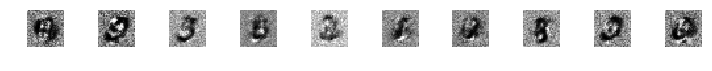

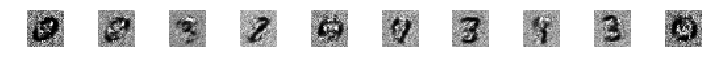

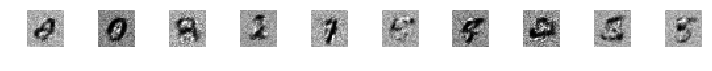

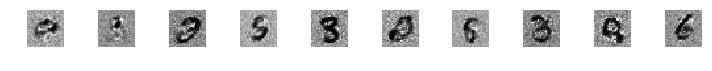

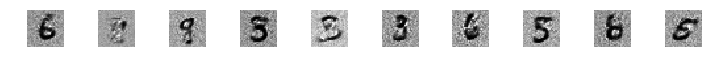

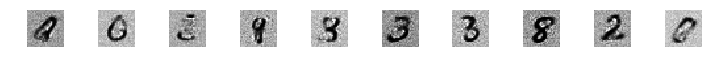

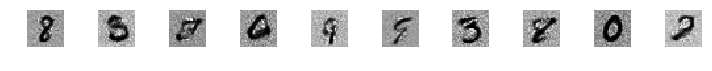

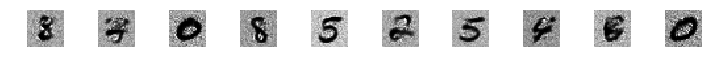

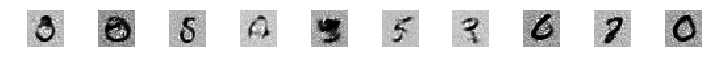

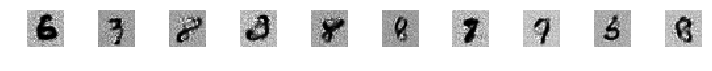

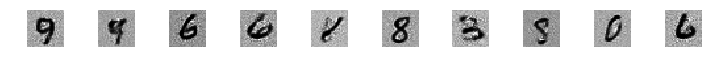

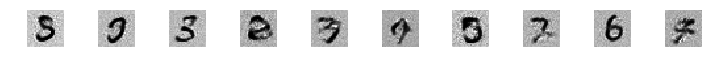

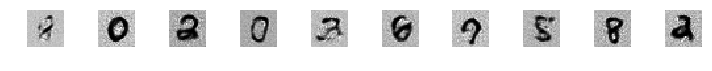

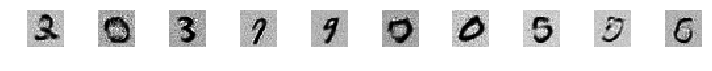

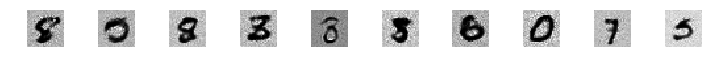

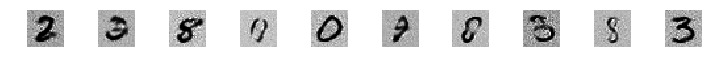

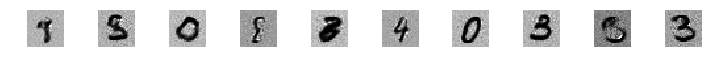

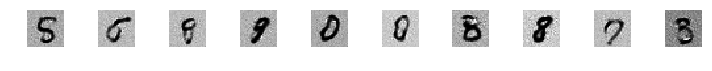

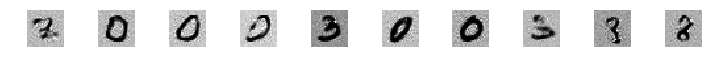

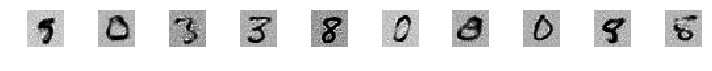

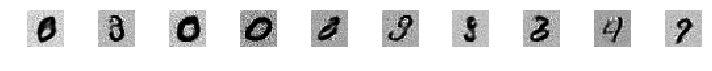

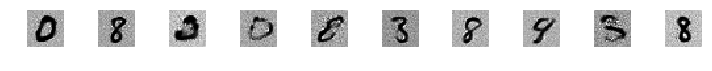

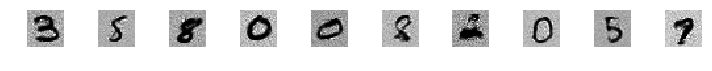

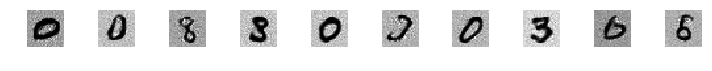

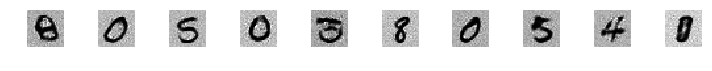

In [12]:
g = train(100, 128)

In [16]:
g = train(10, 32)

  0%|          | 0/1875 [00:00<?, ?it/s]

('---------------', 'Epoch 1', '---------------')


 35%|███▌      | 659/1875 [00:23<00:43, 28.15it/s]

KeyboardInterrupt: 

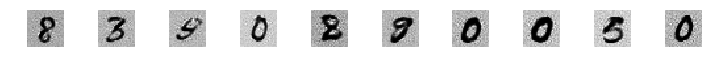

In [145]:
plot_generated_images(1, g)

In [207]:
(img, label, _, _) = load_minst_data()

In [203]:
index = np.random.randint(60000)
i = img[index]

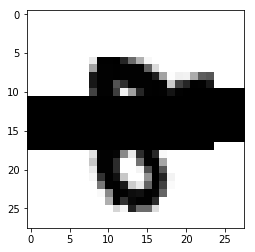

In [204]:
i[300:500] = 1
plt.imshow(i.reshape(28,28), interpolation='nearest', cmap='gray_r')

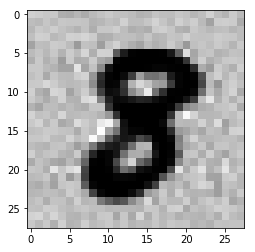

In [205]:
plt.imshow(g.predict(i.reshape(-1, 784)).reshape(28,28), interpolation='nearest', cmap='gray_r')

In [85]:
np.random.randint(60000)

30401

In [213]:
img[[0,1,2,3]]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [214]:
tf.keras.models.save_model(g, "100_epoch_748_input.model")